# Acces to GDrive
These cells give access to your Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import auth
auth.authenticate_user()

#Importations

In [ ]:
import gspread
from oauth2client.client import GoogleCredentials
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import *


import seaborn as sns
import matplotlib.pyplot as plt  

#Data extraction
These cells load the time series (from the json files) and labels (from data.csv).

In [ ]:
gc = gspread.authorize(GoogleCredentials.get_application_default())
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1m2l52fMnXSO_SIp_LRnX-NTjt50RJhwYdJ4cCKX1xa8/edit#gid=0')
data = wb.worksheet('data').get_all_values()
df = pd.DataFrame(data)
df.columns = df.iloc[0]
df = df.iloc[1:]

In [ ]:
start = 0
end = 385
sub_df = df[start:end]
sub_df.head()

,Name,Gender (W/M),"Fail, Zone or Top (0/1/2)",Competition,Climber,Country,Boulder Label
1,c1.mp4,M,0,WC (2021),Yannick Flohé,GER,1
2,c2.mp4,M,0,WC (2021),Jan Hojer,GER,2
3,c3.mp4,M,0,WC (2021),Yannick Flohé,GER,1
4,c4.mp4,M,1,WC (2021),Jan Hojer,GER,2
5,c5.mp4,M,1,WC (2021),Jan Hojer,GER,2


In [ ]:
path = '/content/drive/MyDrive/Boulder Project/'
names = sub_df["Name"].values

In [ ]:
df = []
for idx in range(len(names)):
  for ending in [".MOV", ".mp4"]:
    names[idx] = names[idx].replace(ending, "")
  path_landmarks = path + "json/" + names[idx] + "_landmarks.json"
  data = pd.read_json(path_landmarks)
  data['id'] = [idx]*len(data)
  data['time'] = np.arange(0,len(data))
  df.append(data)

df = pd.concat(df)
keys = df.keys()[:15]
for key in keys:
  x = key + "_x"
  y = key + "_y"
  df[x] = np.vstack(df[key].values)[:,0]
  df[y] = np.vstack(df[key].values)[:,1]

df = df.drop(columns = keys)
y_climber = pd.Series(data = sub_df['Climber'].values, index = np.arange(0,len(names)))
y_success = pd.Series(data = sub_df['Fail, Zone or Top (0/1/2)'].values, index = np.arange(0,len(names)))

#Installation of tsfresh
Warning: After the installation, the notebook has to be rerun again.

In [ ]:
pip install tsfresh

In [ ]:
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

#Features extraction and Features selection with tsfresh
**Remark: The features are stored and do not have to be extracted again for the next parts**

In [ ]:
extracted_features = extract_features(df, column_id="id", column_sort="time")
extracted_features.to_csv('/content/drive/MyDrive/Boulder Project/features/features.csv')

In [ ]:
impute(extracted_features)
features_filtered_climber = select_features(extracted_features, y_climber)
features_filtered_success = select_features(extracted_features, y_success)

In [ ]:
features_filtered_climber.to_csv('/content/drive/MyDrive/Boulder Project/features/features_filtered_climbers.csv')
features_filtered_success.to_csv('/content/drive/MyDrive/Boulder Project/features/features_filtered_success.csv')

#Random Forest 10-fold CV 

In [ ]:
features_filtered_climber = pd.read_csv('/content/drive/MyDrive/Boulder Project/features/features_filtered_climbers.csv')
features_filtered_success = pd.read_csv('/content/drive/MyDrive/Boulder Project/features/features_filtered_success.csv')

**Climber prediction**

In [ ]:
k = 10

N = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
D = [10, 25, 50,100,150]

acc_train = np.zeros((len(N), len(D)))
acc_test = np.zeros((len(N), len(D)))

keys = features_filtered_climber.keys()[1:]
kf = KFold(n_splits=k, shuffle = True, random_state = 1)

for i, n in enumerate(N):
  for j, d in enumerate(D): 
    tmp_train = []
    tmp_test = []
    for train, test in kf.split(y_climber):
      X_train = np.array(features_filtered_climber[keys])[train]
      X_test = np.array(features_filtered_climber[keys])[test]
      Y_train = y_climber[train].values
      Y_test = y_climber[test].values
      clf_climber=RandomForestClassifier(n_estimators=int(n), max_depth = int(d), random_state = 1)
      clf_climber.fit(X_train,Y_train)
      y_pred_test=clf_climber.predict(X_test)
      y_pred_train=clf_climber.predict(X_train)
      tmp_train.append(metrics.accuracy_score(Y_train, y_pred_train))
      tmp_test.append(metrics.accuracy_score(Y_test, y_pred_test))

    acc_train[i,j] = np.mean(tmp_train)
    acc_test[i,j] = np.mean(tmp_test)

In [ ]:
best_test = np.unravel_index(np.argmax(acc_test, axis=None), acc_test.shape) 
print(best_test)
print(acc_test[best_test])

(9, 1)
0.343387314439946


In [ ]:
print(acc_train)
print(acc_test)

[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
[[0.29183536 0.31727395 0.31727395 0.31727395 0.31727395]
 [0.30985155 0.3148448  0.3148448  0.3148448  0.3148448 ]
 [0.29163293 0.31997301 0.31997301 0.31997301 0.31997301]
 [0.28643725 0.31470985 0.31734143 0.31734143 0.31734143]
 [0.30958165 0.33825911 0.34082321 0.34082321 0.34082321]
 [0.31214575 0.34075574 0.34075574 0.34075574 0.34075574]
 [0.29919028 0.33556005 0.33292848 0.33292848 0.33292848]
 [0.30681511 0.33549258 0.33549258 0.33549258 0.33549258]
 [0.30425101 0.33569501 0.33569501 0.33569501 0.33569501]
 [0.3145749  0.34338731 0.34338731 0.34338731 0.34338731]]


**Achievement prediction**

In [ ]:
k = 10

N = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
D = [10, 25, 50,100,150]

acc_train = np.zeros((len(N), len(D)))
acc_test = np.zeros((len(N), len(D)))

keys = features_filtered_success.keys()[1:]
kf = KFold(n_splits=k, shuffle = True, random_state = 1)

for i, n in enumerate(N):
  for j, d in enumerate(D): 
    tmp_train = []
    tmp_test = []
    for train, test in kf.split(y_success):
      X_train = np.array(features_filtered_success[keys])[train]
      X_test = np.array(features_filtered_success[keys])[test]
      Y_train = y_success[train].values
      Y_test = y_success[test].values
      clf_climber=RandomForestClassifier(n_estimators=int(n), max_depth = int(d), random_state = 1)
      clf_climber.fit(X_train,Y_train)
      y_pred_test=clf_climber.predict(X_test)
      y_pred_train=clf_climber.predict(X_train)
      tmp_train.append(metrics.accuracy_score(Y_train, y_pred_train))
      tmp_test.append(metrics.accuracy_score(Y_test, y_pred_test))

    acc_train[i,j] = np.mean(tmp_train)
    acc_test[i,j] = np.mean(tmp_test)

In [ ]:
best_test = np.unravel_index(np.argmax(acc_test, axis=None), acc_test.shape) 
print(best_test)
print(acc_test[best_test])

(9, 0)
0.8026990553306342


In [ ]:
print(acc_train)
print(acc_test)

[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
[[0.78960864 0.78960864 0.78960864 0.78960864 0.78960864]
 [0.7974359  0.79487179 0.79487179 0.79487179 0.79487179]
 [0.79473684 0.79993252 0.79993252 0.79993252 0.79993252]
 [0.79493927 0.79230769 0.79230769 0.79230769 0.79230769]
 [0.7974359  0.7974359  0.7974359  0.7974359  0.7974359 ]
 [0.80006748 0.80006748 0.80006748 0.80006748 0.80006748]
 [0.79230769 0.79493927 0.79493927 0.79493927 0.79493927]
 [0.79487179 0.79750337 0.79750337 0.79750337 0.79750337]
 [0.79750337 0.79487179 0.79487179 0.79487179 0.79487179]
 [0.80269906 0.80006748 0.80006748 0.80006748 0.80006748]]


# Confusion matrix (with Random Forest using the optimized Parameters)

In [ ]:
features_filtered_climber = pd.read_csv('/content/drive/MyDrive/Boulder Project/features/features_filtered_climbers.csv')
features_filtered_success = pd.read_csv('/content/drive/MyDrive/Boulder Project/features/features_filtered_success.csv')

In [ ]:
n_c = 500
d_c = 25
n_s = 500
d_s = 10

**Climber prediction**

In [ ]:
k = 10
unique_c = y_climber.unique()
keys = features_filtered_climber.keys()[1:]
kf = KFold(n_splits=k, shuffle = True, random_state = 1)
M = np.zeros((23,23))
counts = pd.Series(data = np.zeros(23), index = unique_c)
tmp_train = []
tmp_test = []
tmp_ajusted_train = []
tmp_ajusted_test = []

for train, test in kf.split(y_climber):
      X_train = np.array(features_filtered_climber[keys])[train]
      X_test = np.array(features_filtered_climber[keys])[test]
      Y_train = y_climber[train].values
      Y_test = y_climber[test].values
      clf=RandomForestClassifier(n_estimators=n_c, max_depth = d_c, random_state = 1)
      clf.fit(X_train,Y_train)
      y_pred_test=clf.predict(X_test)
      y_pred_train=clf.predict(X_train)
      M = M + metrics.confusion_matrix(Y_test, y_pred_test, labels = unique_c)
      tmp_train.append(metrics.accuracy_score(Y_train, y_pred_train))
      tmp_test.append(metrics.accuracy_score(Y_test, y_pred_test))
      tmp_ajusted_train.append(metrics.balanced_accuracy_score(Y_train, y_pred_train))
      tmp_ajusted_test.append(metrics.balanced_accuracy_score(Y_test, y_pred_test))

M = M/np.sum(M)
print('train accuracy = ' + str(np.mean(tmp_train)))
print('test accuracy = ' +  str(np.mean(tmp_test)))
print('train ajusted accuracy = ' + str(np.mean(tmp_ajusted_train)))
print('test ajusted accuracy = ' +  str(np.mean(tmp_ajusted_test)))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_clas

train accuracy = 1.0
test accuracy = 0.343387314439946
train ajusted accuracy = 1.0
test ajusted accuracy = 0.2919200739736454


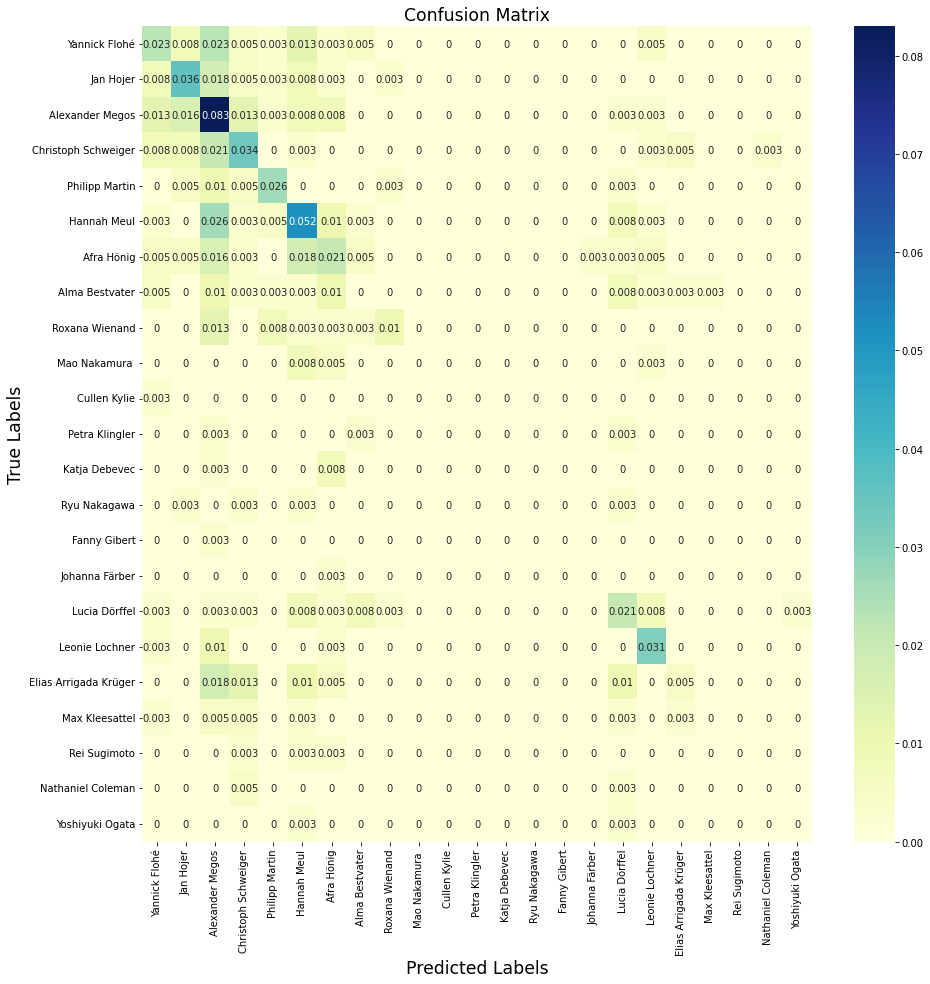

In [ ]:
images_dir = '/content/drive/MyDrive/Boulder Project/figures/'

fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
sns.heatmap(np.round(M,3), annot=True, fmt='g', xticklabels = unique_c, yticklabels = unique_c, ax = ax, cmap="YlGnBu")
ax.set_xlabel('Predicted Labels', fontsize = 'xx-large')
ax.set_ylabel('True Labels', fontsize = 'xx-large')
ax.set_title('Confusion Matrix', fontsize = 'xx-large')
fig.savefig(f"{images_dir}Confusion_Matrix_climber_FullTimeseries.png")
fig.show()

**Achievement prediction**

In [ ]:
k = 10
unique_s = y_success.unique()
keys = features_filtered_success.keys()[1:]
kf = KFold(n_splits=k, shuffle = True, random_state = 1)
M = np.zeros((3,3))
counts = pd.Series(data = np.zeros(3), index = unique_s)
tmp_train = []
tmp_test = []
tmp_ajusted_train = []
tmp_ajusted_test = []

for train, test in kf.split(y_success):
      X_train = np.array(features_filtered_success[keys])[train]
      X_test = np.array(features_filtered_success[keys])[test]
      Y_train = y_success[train].values
      Y_test = y_success[test].values
      clf=RandomForestClassifier(n_estimators=n_s, max_depth = d_s, random_state = 1)
      clf.fit(X_train,Y_train)
      y_pred_test=clf.predict(X_test)
      y_pred_train=clf.predict(X_train)
      M = M + metrics.confusion_matrix(Y_test, y_pred_test, labels = unique_s)
      tmp_train.append(metrics.accuracy_score(Y_train, y_pred_train))
      tmp_test.append(metrics.accuracy_score(Y_test, y_pred_test))
      tmp_ajusted_train.append(metrics.balanced_accuracy_score(Y_train, y_pred_train))
      tmp_ajusted_test.append(metrics.balanced_accuracy_score(Y_test, y_pred_test))

M = M/np.sum(M)
print('train accuracy = ' + str(np.mean(tmp_train)))
print('test accuracy = ' +  str(np.mean(tmp_test)))
print('train ajusted accuracy = ' + str(np.mean(tmp_ajusted_train)))
print('test ajusted accuracy = ' +  str(np.mean(tmp_ajusted_test)))
      

train accuracy = 1.0
test accuracy = 0.8026990553306342
train ajusted accuracy = 1.0
test ajusted accuracy = 0.7398876308647895


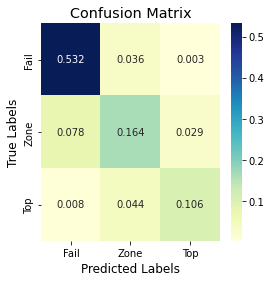

In [ ]:
images_dir = '/content/drive/MyDrive/Boulder Project/figures/'
labels = ['Fail', 'Zone', 'Top']

fig, ax = plt.subplots(figsize=(4,4))         # Sample figsize in inches
sns.heatmap(np.round(M,3), annot=True, fmt='g', xticklabels = labels, yticklabels = labels, ax = ax, cmap="YlGnBu")
ax.set_xlabel('Predicted Labels', fontsize = 'large')
ax.set_ylabel('True Labels', fontsize = 'large')
ax.set_title('Confusion Matrix', fontsize = 'x-large')
fig.savefig(f"{images_dir}Confusion_Matrix_success_FullTimeseries.png")
fig.show()